In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

# conda install -c conda-forge category_encoders
from category_encoders import MEstimateEncoder

# conda install -c conda-forge imbalanced-learn
from imblearn.under_sampling import InstanceHardnessThreshold, NearMiss
from imblearn.over_sampling import ADASYN

In [85]:
promotion_df = pd.read_csv('datasets/promotion.csv')
promotion_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [86]:
# Function for dropping some less important features, null samples, and duplicate samples

def clean_dataset(dataset: pd.DataFrame):

    dataset.drop(['employee_id', 'gender', 'recruitment_channel'], axis=1, inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop_duplicates(inplace=True)

    return dataset

In [87]:
print('Null Values Before', promotion_df.isnull().sum(), sep='\n')
print('\nShape Before:', promotion_df.shape)

promotion_df = clean_dataset(promotion_df)

print('\nShape After:', promotion_df.shape)

Null Values Before
employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

Shape Before: (54808, 14)

Shape After: (48295, 11)


In [88]:
promotion_df.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,48295.000000,48295.000000,48295.000000,48295.000000,48295.000000,48295.000000,48295.000000,48295.000000
mean,1.253235,35.610394,3.337406,6.318625,0.357056,0.023315,63.625096,0.087545
std,0.606506,7.543641,1.257824,4.211537,0.479136,0.150904,13.279887,0.282635
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,30.000000,3.000000,3.000000,0.000000,0.000000,52.000000,0.000000
50%,1.000000,34.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,8.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [89]:
# Counting categorical features to determine encoding method

print("\nDEPARTMENT COUNT")
print(promotion_df['department'].value_counts())

print("\nEDUCATION COUNT")
print(promotion_df['education'].value_counts())


DEPARTMENT COUNT
Sales & Marketing    14107
Operations           10448
Procurement           6595
Technology            6467
Analytics             4581
Finance               2211
HR                    2130
R&D                    891
Legal                  865
Name: department, dtype: int64

EDUCATION COUNT
Bachelor's          33101
Master's & above    14741
Below Secondary       453
Name: education, dtype: int64


In [90]:
print("\nREGION COUNT")
print(promotion_df['region'].value_counts())

print("\nIS_PROMOTED COUNT")
print(promotion_df['is_promoted'].value_counts())


REGION COUNT
region_2     10689
region_22     5379
region_7      4360
region_15     2486
region_13     2453
region_26     1956
region_31     1683
region_4      1623
region_27     1406
region_16     1311
region_11     1181
region_28     1139
region_23     1101
region_29      888
region_19      836
region_20      775
region_14      768
region_32      766
region_17      737
region_25      717
region_5       686
region_10      613
region_30      601
region_6       577
region_8       573
region_1       551
region_24      459
region_12      423
region_21      370
region_3       330
region_9       322
region_33      260
region_34      252
region_18       24
Name: region, dtype: int64

IS_PROMOTED COUNT
0    44067
1     4228
Name: is_promoted, dtype: int64


In [63]:
one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int8)
m_estimate_encoder = MEstimateEncoder()
scaler = StandardScaler()

In [64]:
def encode_dataset(dataset: pd.DataFrame):
    dataset[['department', 'region']] = m_estimate_encoder.transform(dataset[['department', 'region']])
    education_data = one_hot_encoder.transform(dataset[['education']])
    education_dataset = pd.DataFrame(
        education_data, columns=one_hot_encoder.get_feature_names_out(),
    )
    dataset.drop('education', axis=1, inplace=True)
    dataset = dataset.reset_index(drop=True).join(
        education_dataset.reset_index(drop=True),
    )
    return dataset

In [65]:
def scale(data):
    return scaler.transform(data)

In [66]:
promotion_df_labels = promotion_df.pop('is_promoted')

# Keeping original feature names
promotion_df_features = promotion_df.columns.array

# Encoding
m_estimate_encoder.fit(promotion_df[['department', 'region']], promotion_df_labels)
one_hot_encoder.fit(promotion_df[['education']])
promotion_df = encode_dataset(promotion_df)

# Keeping updated feature names for plotting
promotion_df_features_upd = promotion_df.columns.array

In [67]:
print(promotion_df_labels.value_counts())

0    44067
1     4228
Name: is_promoted, dtype: int64


In [68]:
# Balancing Data - Part 1
# Under Sampling
under_sampler_iht = InstanceHardnessThreshold(random_state=42, n_jobs=2)
under_sampler_nm = NearMiss(version=2, sampling_strategy=0.7, n_jobs=2)

print('DATASET VALUE COUNTS BEFORE UNDERSAMPLING:', promotion_df_labels.value_counts(), sep='\n', end='\n\n')

promotion_df, promotion_df_labels = under_sampler_iht.fit_resample(promotion_df, promotion_df_labels)

print('DATASET VALUE COUNTS AFTER UNDERSAMPLING WITH IHT:', promotion_df_labels.value_counts(), sep='\n')

promotion_df, promotion_df_labels = under_sampler_nm.fit_resample(promotion_df, promotion_df_labels)

print('DATASET VALUE COUNTS AFTER UNDERSAMPLING WITH NEARMISS:', promotion_df_labels.value_counts(), sep='\n')

# Over Sampling will be done only on the training data to avoid having synthetic data in the testing data, 
# because we want to be assess the model based on its performance on real data.

DATASET VALUE COUNTS BEFORE UNDERSAMPLING:
0    44067
1     4228
Name: is_promoted, dtype: int64

DATASET VALUE COUNTS AFTER UNDERSAMPLING WITH IHT:
0    19416
1     4228
Name: is_promoted, dtype: int64
DATASET VALUE COUNTS AFTER UNDERSAMPLING WITH NEARMISS:
0    6040
1    4228
Name: is_promoted, dtype: int64


In [69]:
promotion_df.describe()

,department,region,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,education_Bachelor's,education_Below Secondary,education_Master's & above
count,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000,10268.000000
mean,0.095149,0.087955,1.239092,36.215232,3.285840,6.620764,0.295092,0.049085,70.461434,0.651344,0.003603,0.345053
std,0.011208,0.025866,0.586032,6.713874,1.193554,3.793276,0.456106,0.216055,11.217003,0.476568,0.059923,0.475409
min,0.048600,0.025039,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,41.000000,0.000000,0.000000,0.000000
25%,0.093414,0.074236,1.000000,31.000000,3.000000,4.000000,0.000000,0.000000,61.000000,0.000000,0.000000,0.000000
50%,0.098709,0.082796,1.000000,35.000000,3.000000,6.000000,0.000000,0.000000,70.000000,1.000000,0.000000,0.000000
75%,0.098709,0.109399,1.000000,40.000000,4.000000,8.000000,1.000000,0.000000,79.000000,1.000000,0.000000,1.000000
max,0.107311,0.147221,9.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000,1.000000,1.000000,1.000000


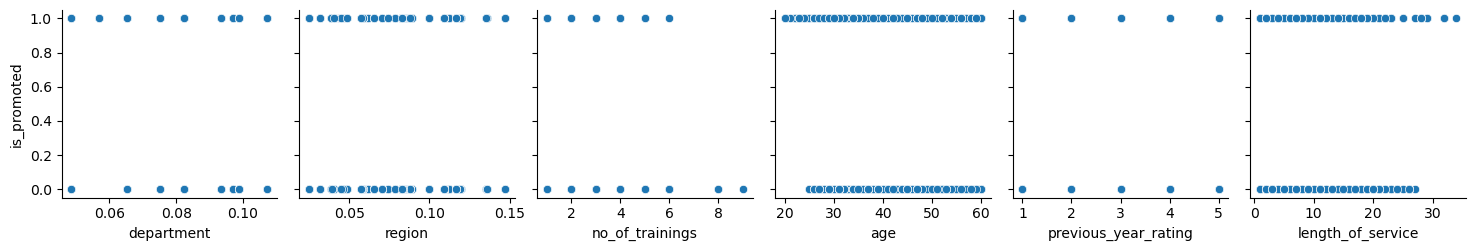

In [70]:
promotion_df['is_promoted'] = promotion_df_labels
sns.pairplot(promotion_df, x_vars=promotion_df_features_upd[:6], y_vars=['is_promoted'])

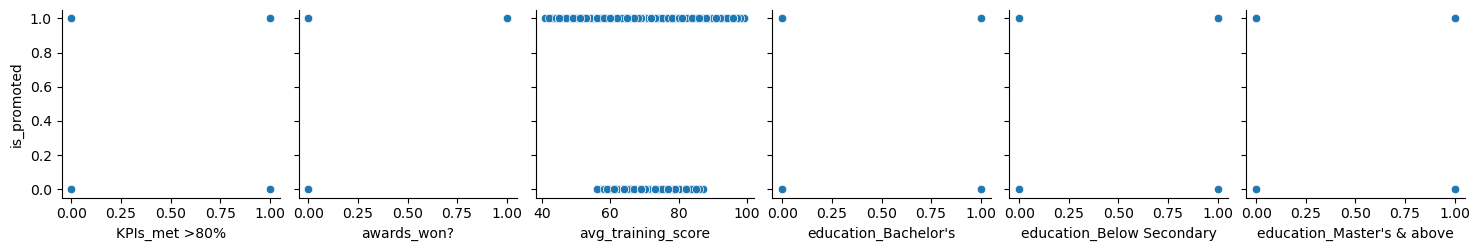

In [71]:
sns.pairplot(promotion_df, x_vars=promotion_df_features_upd[6:], y_vars=['is_promoted'])

In [72]:
promotion_df.head()

,department,region,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,education_Bachelor's,education_Below Secondary,education_Master's & above,is_promoted
0,0.098709,0.147221,1,41,2.0,12,0,0,71,0,0,1,0
1,0.098709,0.074236,1,42,4.0,12,0,0,71,0,0,1,0
2,0.098709,0.147221,1,41,3.0,11,0,0,71,0,0,1,0
3,0.098709,0.082796,1,39,1.0,15,0,0,71,1,0,0,0
4,0.098709,0.116373,1,39,1.0,13,0,0,71,0,0,1,0


In [73]:
Y = promotion_df.pop('is_promoted')

scaler.fit(promotion_df)
X = scale(promotion_df)

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    X, Y, test_size=0.3, random_state=42,
)

In [74]:
# Balancing Data - Part 2
# Over Sampling
over_sampler = ADASYN(sampling_strategy=0.8, random_state=42)

print('TRAINING DATA VALUE COUNTS BEFORE OVERSAMPLING:', Y_TRAIN.value_counts(), sep='\n', end='\n\n')

X_TRAIN, Y_TRAIN = over_sampler.fit_resample(X_TRAIN, Y_TRAIN)

print('TRAINING DATA VALUE COUNTS AFTER OVERSAMPLING:', Y_TRAIN.value_counts(), sep='\n')

TRAINING DATA VALUE COUNTS BEFORE OVERSAMPLING:
0    4190
1    2997
Name: is_promoted, dtype: int64

TRAINING DATA VALUE COUNTS AFTER OVERSAMPLING:
0    4190
1    3270
Name: is_promoted, dtype: int64


In [75]:
model_rf = RandomForestClassifier(n_jobs=2)
model_nb = BernoulliNB()
model_nn = MLPClassifier(random_state=42, max_iter=1000)
model_svm = SVC()

# Training the model
model_rf.fit(X_TRAIN, Y_TRAIN)
model_nb.fit(X_TRAIN, Y_TRAIN)
model_nn.fit(X_TRAIN, Y_TRAIN)
model_svm.fit(X_TRAIN, Y_TRAIN)
print('TRAINING COMPLETE')

TRAINING COMPLETE


In [76]:
# 5-Fold CROSS VALIDATION
print(
    'RF 5-Fold Test Accuracy Scores:',
    cross_validate(estimator=model_rf, X=X_TRAIN, y=Y_TRAIN, cv=5, n_jobs=2)['test_score'],
    sep='\n'
)
print(
    'NB 5-Fold Test Accuracy Scores:',
    cross_validate(estimator=model_nb, X=X_TRAIN, y=Y_TRAIN, cv=5, n_jobs=2)['test_score'],
    sep='\n'
)
print(
    'NN 5-Fold Test Accuracy Scores:',
    cross_validate(estimator=model_nn, X=X_TRAIN, y=Y_TRAIN, cv=5, n_jobs=2)['test_score'],
    sep='\n'
)
print(
    'SVM 5-Fold Test Accuracy Scores:',
    cross_validate(estimator=model_svm, X=X_TRAIN, y=Y_TRAIN, cv=5, n_jobs=2)['test_score'],
    sep='\n'
)

RF 5-Fold Test Accuracy Scores:
[0.98123324 0.9886059  0.98190349 0.98190349 0.96514745]
NB 5-Fold Test Accuracy Scores:
[0.90147453 0.88873995 0.89678284 0.88404826 0.76675603]
NN 5-Fold Test Accuracy Scores:
[0.96782842 0.97587131 0.97184987 0.97587131 0.97252011]
SVM 5-Fold Test Accuracy Scores:
[0.95844504 0.95844504 0.9577748  0.96447721 0.88002681]


In [77]:
Y_TEST_PRED_RF = model_rf.predict(X_TEST)
Y_TEST_PRED_NB = model_nb.predict(X_TEST)
Y_TEST_PRED_NN = model_nn.predict(X_TEST)
Y_TEST_PRED_SVM = model_svm.predict(X_TEST)

MODEL ASSESSMENT RF

Confusion Matrix
 [[1819   31]
 [  19 1212]]

            Accuracy :  0.9837715027588445
Recall / Sensitivity :  0.9845653939886271
         Specificity :  0.9832432432432432
           Precision :  0.9750603378921963
                 MCC :  0.9662645942894632
            F1-Score :  0.9797898140662894


<AxesSubplot: >

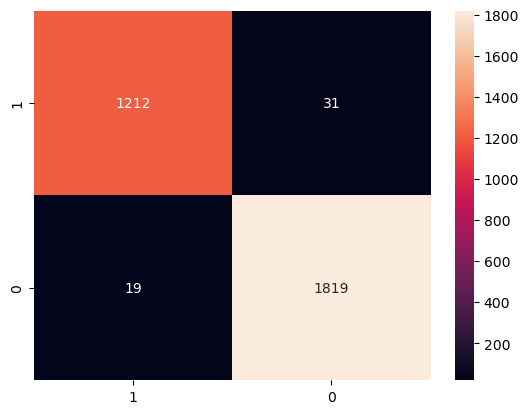

In [78]:
conf_mat = confusion_matrix(Y_TEST, Y_TEST_PRED_RF)

TN, FP, FN, TP = conf_mat.ravel()

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)
mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
f1_score_ = (2 * precision * recall) / (precision + recall)

print('MODEL ASSESSMENT RF')
print('\nConfusion Matrix\n', conf_mat, end='\n\n')
print('            Accuracy : ', accuracy)
print('Recall / Sensitivity : ', recall)
print('         Specificity : ', specificity)
print('           Precision : ', precision)
print('                 MCC : ', mcc)
print('            F1-Score : ', f1_score_)

sns.heatmap([[TP, FP], [FN, TN]], annot=True, fmt='g', xticklabels=[1, 0], yticklabels=[1, 0])

MODEL ASSESSMENT NB

Confusion Matrix
 [[1758   92]
 [ 224 1007]]

            Accuracy :  0.8974358974358975
Recall / Sensitivity :  0.818034118602762
         Specificity :  0.9502702702702702
           Precision :  0.916287534121929
                 MCC :  0.7855928705125373
            F1-Score :  0.8643776824034334


<AxesSubplot: >

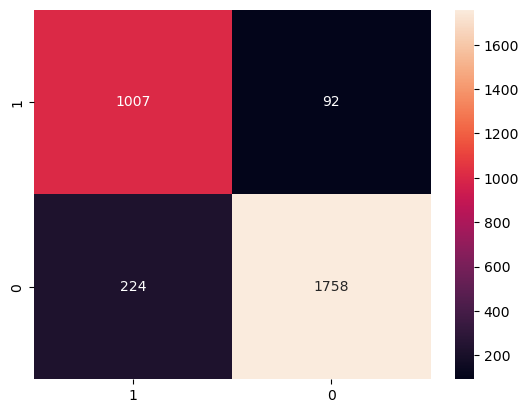

In [79]:
conf_mat = confusion_matrix(Y_TEST, Y_TEST_PRED_NB)

TN, FP, FN, TP = conf_mat.ravel()

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)
mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
f1_score_ = (2 * precision * recall) / (precision + recall)

print('MODEL ASSESSMENT NB')
print('\nConfusion Matrix\n', conf_mat, end='\n\n')
print('            Accuracy : ', accuracy)
print('Recall / Sensitivity : ', recall)
print('         Specificity : ', specificity)
print('           Precision : ', precision)
print('                 MCC : ', mcc)
print('            F1-Score : ', f1_score_)

sns.heatmap([[TP, FP], [FN, TN]], annot=True, fmt='g', xticklabels=[1, 0], yticklabels=[1, 0])

MODEL ASSESSMENT NN

Confusion Matrix
 [[1812   38]
 [  29 1202]]

            Accuracy :  0.9782538136968517
Recall / Sensitivity :  0.9764419171405362
         Specificity :  0.9794594594594594
           Precision :  0.9693548387096774
                 MCC :  0.9547512614969038
            F1-Score :  0.9728854714690408


<AxesSubplot: >

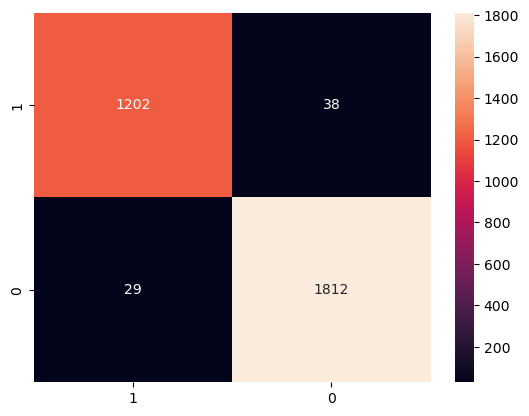

In [80]:
conf_mat = confusion_matrix(Y_TEST, Y_TEST_PRED_NN)

TN, FP, FN, TP = conf_mat.ravel()

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)
mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
f1_score_ = (2 * precision * recall) / (precision + recall)

print('MODEL ASSESSMENT NN')
print('\nConfusion Matrix\n', conf_mat, end='\n\n')
print('            Accuracy : ', accuracy)
print('Recall / Sensitivity : ', recall)
print('         Specificity : ', specificity)
print('           Precision : ', precision)
print('                 MCC : ', mcc)
print('            F1-Score : ', f1_score_)

sns.heatmap([[TP, FP], [FN, TN]], annot=True, fmt='g', xticklabels=[1, 0], yticklabels=[1, 0])

MODEL ASSESSMENT SVM

Confusion Matrix
 [[1784   66]
 [  48 1183]]

            Accuracy :  0.9629990262901655
Recall / Sensitivity :  0.9610073111291633
         Specificity :  0.9643243243243244
           Precision :  0.9471577261809447
                 MCC :  0.9231416526192711
            F1-Score :  0.9540322580645161


<AxesSubplot: >

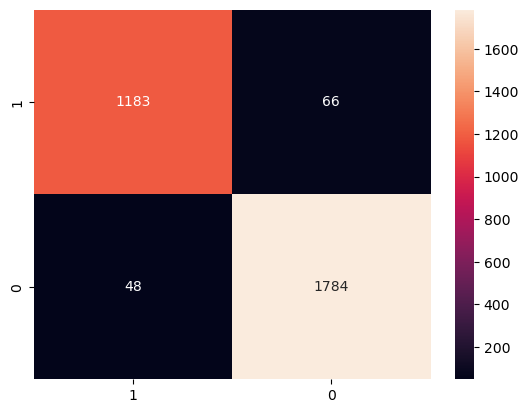

In [81]:
conf_mat = confusion_matrix(Y_TEST, Y_TEST_PRED_SVM)

TN, FP, FN, TP = conf_mat.ravel()

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)
mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
f1_score_ = (2 * precision * recall) / (precision + recall)

print('MODEL ASSESSMENT SVM')
print('\nConfusion Matrix\n', conf_mat, end='\n\n')
print('            Accuracy : ', accuracy)
print('Recall / Sensitivity : ', recall)
print('         Specificity : ', specificity)
print('           Precision : ', precision)
print('                 MCC : ', mcc)
print('            F1-Score : ', f1_score_)

sns.heatmap([[TP, FP], [FN, TN]], annot=True, fmt='g', xticklabels=[1, 0], yticklabels=[1, 0])